In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import IPython.display as display

class NeuralNetworkLayer(nn.Module):
    def __init__(self):
        super(NeuralNetworkLayer, self).__init__()

        #Layer 1 Input: 17 Output: 3
        self.layer1 = nn.Linear(17, 5)
        #self.layer1.weight.data.fill_(0.4)
        #self.layer1.bias.data.fill_(0.01)
        #Layer 3 Input: 3 Output: 1
        self.layer2 = nn.Linear(5, 1)
        #self.layer2.weight.data.fill_(0.2)
        #self.layer2.bias.data.fill_(0.01)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        return x

In [2]:

def importMonkDataset(file_name:str) -> pd.DataFrame:
    dataset = None
    columns_name = ["Y"] + [f"X{i}" for i in range(1,7)] + ["ID"]
    try:
        dataset = pd.read_csv(file_name, sep=" ", names=columns_name)
    except Exception as e:
        print("Error | Parsing target dataset for validation!")
        print(e)
    dataset.set_index('ID', inplace=True)
    return dataset

def takeMonkInputDataset(dataset:pd.DataFrame) -> pd.DataFrame:
    return dataset.iloc[:, 1:] #Return dataset without first and last column
 
def takeMonkOutputDataset(dataset:pd.DataFrame) -> pd.DataFrame:
    return dataset.iloc[:,[0]] #Return dataset with only first column


def convert_x(x_train: np.ndarray):
    dict_3 = {1: [1, 0, 0], 2: [0, 1, 0], 3: [0, 0, 1]}
    dict_2 = {1: [1, 0], 2: [0, 1]}
    dict_4 = {1: [1, 0, 0, 0], 2: [0, 1, 0, 0], 3: [0, 0, 1, 0], 4: [0, 0, 0, 1]}

    new_y = []

    for row in x_train:
        new_row = []
        for j, value in enumerate(row):
            if j in [0, 1, 3]:
                new_row.extend(dict_3.get(value))
            elif j in [2, 5]:
                new_row.extend(dict_2.get(value))
            elif j == 4:
                new_row.extend(dict_4.get(value))

        new_y.append(new_row)
    return new_y

In [3]:
dataset_train = importMonkDataset("MONK/monks-1.train")
x_train = takeMonkInputDataset(dataset_train)
y_train = takeMonkOutputDataset(dataset_train)

#Convert data
x_train = convert_x(x_train.to_numpy())
y_train = y_train.to_numpy()

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

#Net
net = NeuralNetworkLayer()

In [4]:
from torch.utils.data import TensorDataset, DataLoader

#Move data to gpu
net = net.to("cuda:0")
x_train = x_train.to("cuda:0")
y_train = y_train.to("cuda:0")

#net = net.double()
#x_train = x_train.double()
#y_train = y_train.double()

dataset_train = TensorDataset(x_train, y_train)
data_loader = DataLoader(dataset_train, batch_size=10, shuffle=True)

In [5]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
for p in net.parameters():
    print(p)

Parameter containing:
tensor([[-0.0776, -0.0704, -0.0284, -0.1729, -0.0498, -0.0028, -0.1353, -0.1390,
          0.1027, -0.2390, -0.0143,  0.1883, -0.0052, -0.2138, -0.0293, -0.2110,
          0.2195],
        [ 0.1382,  0.2424,  0.0724, -0.0778, -0.0734, -0.0433,  0.1016,  0.0256,
         -0.1193,  0.2112, -0.1206, -0.1987, -0.2005,  0.1512, -0.0047,  0.0878,
          0.0799],
        [-0.1739, -0.1761, -0.0429,  0.0624,  0.1914,  0.0559,  0.1949, -0.2293,
          0.1978, -0.1820, -0.2281,  0.0398,  0.1475, -0.0574,  0.1804, -0.0915,
          0.0210],
        [-0.0282, -0.1788, -0.2072,  0.1157,  0.0265, -0.0449,  0.2093, -0.1094,
         -0.1725, -0.0296,  0.1559, -0.2231, -0.0240, -0.1089,  0.0231,  0.1680,
          0.1988],
        [ 0.1406, -0.0108, -0.0702, -0.1268, -0.2392,  0.1122,  0.0980, -0.0616,
          0.0839, -0.0104,  0.1196, -0.1881,  0.2118,  0.1733, -0.0658,  0.2213,
          0.0411]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.10

In [6]:
# activation: tanh, relu
# solver: sgd, adam
# lr: 0.01, 0.001, 0.05, 0.005
# iter: 350, 400
# alpha: 0.0001, 0.001, 0.0005, 0.005
# layers: 2, 3, 4

# parameters = {'activation':('tanh', 'relu'), 
#               'solver':('sgd', 'adam'), 
#               'lr':('0.01', '0.001', '0.05', '0.005'), 
#               'epochs': ('350', '400', '450'),
#               'alpha' : ('0.0001', '0.001', '0.0005', '0.005'),
#               'layers' : ('2', '3', '4')}

parameters = {'lr':('0.01', '0.001', '0.05', '0.005')}

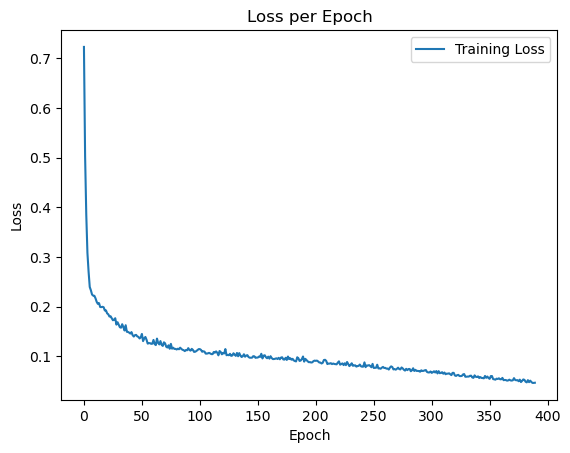

Epoch [390/390], Loss: 0.0468


In [7]:
print(net.parameters())
loss_values = []
epochs = 390
for epoch in range(epochs):
    total_loss = 0
    for batch_input, batch_output in data_loader:
        #Forward pass
        outputs = net(batch_input)
        #Training loss
        loss = criterion(outputs, batch_output)
        #Calculate accuracy
        
        #Outputs convert to binary 0 or 1 with P (Probability)
        #outputsConv = (F.sigmoid(outputs) >= 0.5).float()
        #_, predicted = torch.max(outputsConv.data, 1)
        total_loss += loss.item()
        #Backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    avg_loss = total_loss / len(data_loader)
    #Add to list
    loss_values.append(avg_loss)

    #Update plot
    display.clear_output(wait=True)
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

In [8]:
torch.save(net, 'model390.pth')

In [9]:
dataset_test = importMonkDataset("MONK/monks-1.test")

x_test = takeMonkInputDataset(dataset_test)
y_test = takeMonkOutputDataset(dataset_test)
x_test = x_test.to_numpy()

x_test = convert_x(x_test)
y_test = y_test.to_numpy()

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

x_test = x_test.to("cuda:0")
y_test = y_test.to("cuda:0")

net = net.double()
x_test = x_test.double()
y_test = y_test.double()

dataset_test = TensorDataset(x_test, y_test)
data_loader = DataLoader(dataset_test, batch_size=10, shuffle=True)

total = 0
correct = 0
net.eval()
with torch.no_grad():
    for batch_input, batch_output in data_loader:
        outputs = net(batch_input)
        predicted = (outputs > 0.5).float()
        total += batch_input.size(0)
        correct += (predicted == batch_output).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')
    

Accuracy: 0.9560
